Install dependencies

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure

import gym
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import random
from gym import wrappers
import copy
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from IPython.display import Video
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import sys
Running_in_colab = 'google.colab' in sys.modules

display = Display(visible=0, size=(1400, 900))
display.start()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

from PartI_lib import archs as archs
from PartI_lib import performance_evaluation as eval
from PartI_lib import train_loop as tl
from PartI_lib import my_tools as mt
# !mkdir Checkpoints
import time


True
cuda:0


In [3]:
#@title Deep RL Replay Buffer

class ReplayBuffer:
    def __init__(self, size, input_shape,dev):
        self.size = size
        self.counter = 0
        self.state_buffer = torch.zeros((self.size, input_shape))
        self.action_buffer = torch.zeros(self.size, dtype=torch.int64)
        self.reward_buffer = torch.zeros(self.size)
        self.new_state_buffer = torch.zeros((self.size, input_shape))
        self.terminal_buffer = torch.zeros(self.size)
        self.state_buffer.to(dev)
        self.action_buffer.to(dev)
        self.reward_buffer.to(dev)
        self.new_state_buffer.to(dev)
        self.terminal_buffer.to(dev)
        self.dev=dev;



    def store_tuples(self, state, action, reward, new_state, done):
        idx = self.counter % self.size
        self.state_buffer[idx] = state
        self.action_buffer[idx] = action
        self.reward_buffer[idx] = reward
        self.new_state_buffer[idx] = new_state
        self.terminal_buffer[idx] = done
        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state_buffer[batch].to(self.dev)
        action_batch = self.action_buffer[batch].to(self.dev)
        reward_batch = self.reward_buffer[batch].to(self.dev)
        new_state_batch = self.new_state_buffer[batch].to(self.dev)
        done_batch = self.terminal_buffer[batch].to(self.dev)

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch
    def last_buffer(self, batch_size):
        state_batch = self.state_buffer[-1:-batch_size].to(self.dev)
        action_batch = self.action_buffer[-1:-batch_size].to(self.dev)
        reward_batch = self.reward_buffer[-1:-batch_size].to(self.dev)
        new_state_batch = self.new_state_buffer[-1:-batch_size].to(self.dev)
        done_batch = self.terminal_buffer[-1:-batch_size].to(self.dev)

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch


Default DQN arquitecture

OpenAI Environment CartPole-v0

###    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.
###    Source:
        This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson
###    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
###    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not fixed; it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it
###    Reward:
        Reward is 1 for every step taken, including the termination step
###    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
###    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of the display).
        Episode length is greater than 200.
###     Solved Requirements:
        Considered solved when the average return is greater than or equal to 195.0 over 20 consecutive trials.

In [4]:
#@title DQN movie generation (for visual evaluation in Google Colab)

def createMovie(Network,path,Filename):
    env = gym.make("CartPole-v0")
    envX = wrappers.Monitor(env,path+'/'+Filename,force=True)

    observation = envX.reset()

    i=0
    Network.eval()

    while True:
        envX.render()
        
        state=torch.Tensor(observation).to(device)
      
        action = Network.policy(state);
             
        observation, reward, done, info = envX.step(action.item()) 
        i=i+1;     
        if done: 
          break;

    envX.close()
    env.close();
    Network.train()
    mp4list = glob.glob(path+Filename+'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        if(Running_in_colab):
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
        else:
            # print("Loc Video")
            # print(mp4)
            # print("VIDEO PR")
            Video(mp4)

            # HTML("""
            #         <video alt="test" controls>
            #             <source src="test.mp4" type="video/mp4">
            #         </video>
            #     """)
    else: 
        print("Could not find video")

In [5]:
# from IPython.display import HTML

# Video("openaigym.video.19.10825.video000000.mp4")
# HTML('<iframe width="560" height="315" src="openaigym.video.19.10825.video000000.mp4" frameborder="0" allowfullscreen></iframe>')

Run the new netwwork with random policy

In [6]:
# randomnet=RandomNet(2)
# createMovie(randomnet,"random")

Initialization and Parameters:


DQN_128_1_001_2e-03_099_1e+00_099
0 of 2000
27.0 27 27.0 27.0
38.0 38 22.2 22.2
25 of 2000
53.0 53 20.65 19.710526315789473
50 of 2000
75 of 2000
100 of 2000
55.0 55 21.5 20.65
125 of 2000
56.0 56 23.45 20.97
150 of 2000
175 of 2000
200 of 2000
65.0 65 24.95 21.19
76.0 76 27.2 21.85
225 of 2000
125.0 125 28.15 22.42
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
140.0 140 43.25 21.47
800 of 2000
144.0 144 60.1 35.84
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
148.0 148 52.8 49.57
184.0 184 69.5 53.01
950 of 2000
975 of 2000
1000 of 2000
200.0 200 64.05 46.82
200.0 200 93.55 52.53
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 200

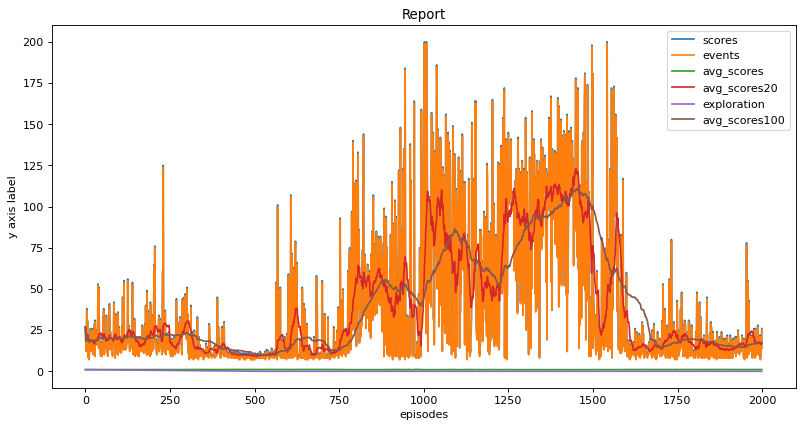

Could not find video
DQN_128_1_001_2e-03_099_1e-01_099
0 of 2000
14.0 14 14.0 14.0
17.0 17 15.5 15.5
19.0 19 16.666666666666668 16.666666666666668
34.0 34 21.0 21.0
36.0 36 22.5 22.5
37.0 37 22.76923076923077 22.76923076923077
25 of 2000
53.0 53 21.2 21.818181818181817
67.0 67 25.25 22.58
50 of 2000
67.0 67 28.95 24.50943396226415
75 of 2000
70.0 70 34.1 26.913978494623656
113.0 113 36.5 27.6
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
122.0 122 57.0 29.52
123.0 123 69.45 32.58
350 of 2000
375 of 2000
400 of 2000
425 of 2000
124.0 124 38.4 42.63
450 of 2000
133.0 133 40.95 39.9
475 of 2000
500 of 2000
154.0 154 38.15 38.48
200.0 200 46.75 40.09
525 of 2000
200.0 200 47.0 41.95
550 of 2000
575 of 2000
600 of 2000
200.0 200 52.45 48.23
625 of 2000
200.0 200 55.4 50.66
650 of 2000
200.0 200 76.7 53.09
200.0 200 69.45 54.44
200.0 200 76.1 55.73
200.0 200 72.55 55.67
675 of 2000
200.0 200 79.05 61.72
700 of 2000
200

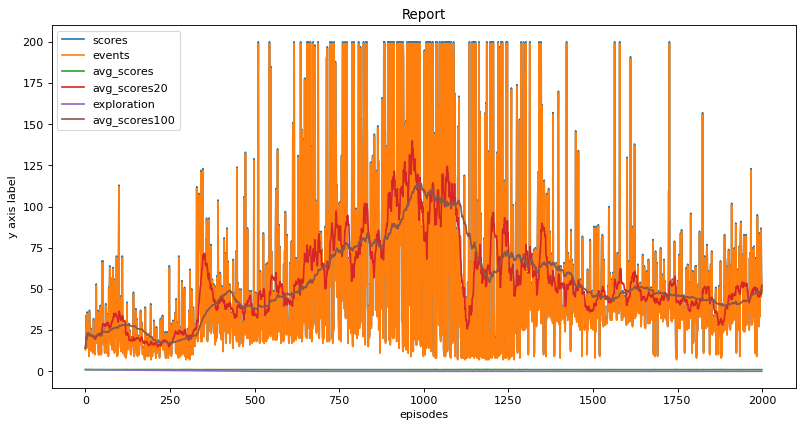

Could not find video
DQN_128_1_001_2e-03_099_1e-02_099
0 of 2000
14.0 14 14.0 14.0
29.0 29 21.5 21.5
38.0 38 27.0 27.0
43.0 43 20.571428571428573 20.571428571428573
53.0 53 22.0 22.0
25 of 2000
57.0 57 22.8 22.6
69.0 69 24.7 23.608695652173914
50 of 2000
75 of 2000
95.0 95 28.85 23.811764705882354
100 of 2000
125 of 2000
97.0 97 39.3 30.45
150 of 2000
119.0 119 43.2 34.61
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
143.0 143 49.1 42.14
550 of 2000
575 of 2000
200.0 200 69.0 52.91
600 of 2000
625 of 2000
650 of 2000
675 of 2000
200.0 200 105.55 89.27
700 of 2000
725 of 2000
750 of 2000
200.0 200 130.3 111.05
200.0 200 134.35 112.45
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000


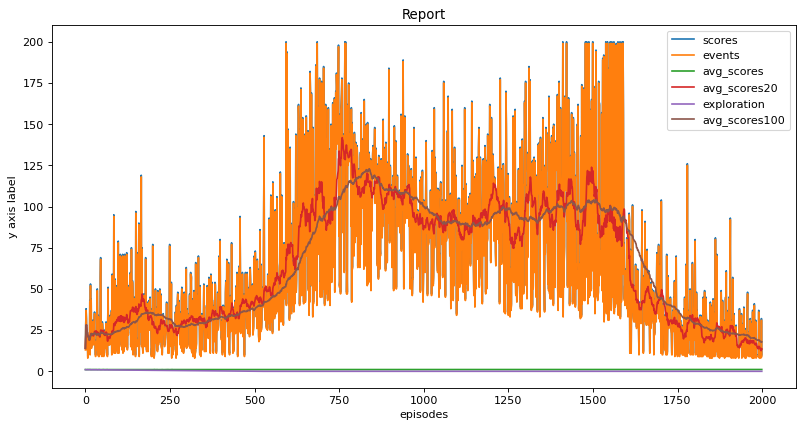

Could not find video
DQN_128_1_001_2e-03_099_1e-01_099
0 of 2000
23.0 23 23.0 23.0
27.0 27 25.0 25.0
27.0 27 25.666666666666668 25.666666666666668
45.0 45 18.55 18.761904761904763
25 of 2000
79.0 79 21.75 20.5
79.0 79 28.05 23.07894736842105
50 of 2000
87.0 87 24.4 23.13235294117647
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
1475 of 2000
1500 of 2000


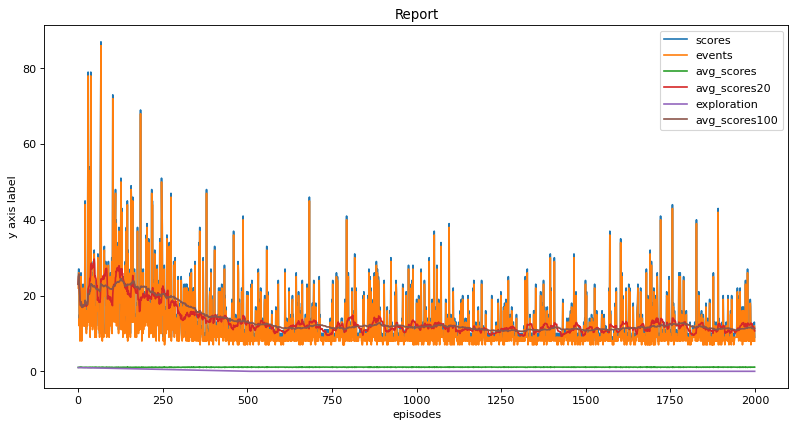

Could not find video
DQN_128_1_001_2e-03_099_1e-02_099
0 of 2000
22.0 22 22.0 22.0
27.0 27 19.666666666666668 19.666666666666668
29.0 29 20.666666666666668 20.666666666666668
33.0 33 20.545454545454547 20.545454545454547
56.0 56 20.6 20.6
25 of 2000
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
1475 of 2000
1500 of 2000
1525 of 2000
1550 of 20

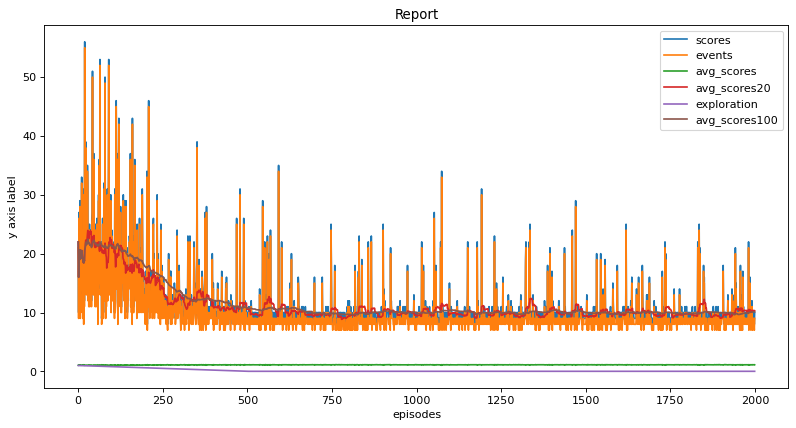

Could not find video
DQN_128_1_001_2e-03_099_1e-05_099
0 of 2000
47.0 47 47.0 47.0
25 of 2000
58.0 58 22.15 21.6875
61.0 61 26.0 23.08695652173913
71.0 71 28.5 23.816326530612244
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
72.0 72 21.8 20.96
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
1475 of 2000
1500 of 2000
1525 of 2000
1550 of 2000
1575 of 2000
1600 of 2000
1625 of 2000
1650 of 20

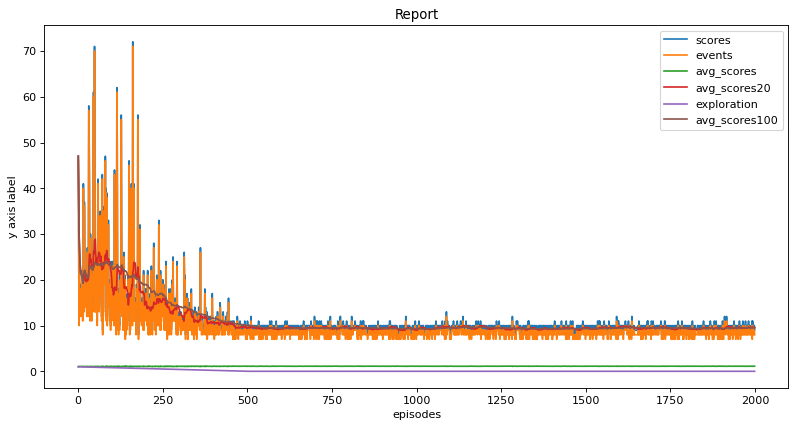

Could not find video
DQN_128_1_001_2e-03_099_1e-03_099
0 of 2000
18.0 18 18.0 18.0
46.0 46 23.0 23.0
48.0 48 24.571428571428573 24.571428571428573
56.0 56 26.833333333333332 26.833333333333332
25 of 2000
80.0 80 26.3 25.0
50 of 2000
141.0 141 30.35 25.675675675675677
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
156.0 156 35.55 35.28
200 of 2000
200.0 200 49.5 38.43
225 of 2000
200.0 200 60.5 43.25
250 of 2000
275 of 2000
200.0 200 49.25 48.26
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
200.0 200 80.85 67.54
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
200.0 200 121.2 107.82
200.0 200 150.8 114.3
600 of 2000
200.0 200 145.25 118.58
200.0 200 147.95 122.26
200.0 200 140.65 124.59
625 of 2000
200.0 200 144.15 128.4
200.0 200 147.45 129.46
200.0 200 150.85 130.5
200.0 200 145.5 135.53
200.0 200 149.15 136.53
200.0 200 151.15 137.88
200.0 200 152.55 138.88
200.0 200 152.55 139.83
200.0 200 152.55 140.83
650 of 2000
200.0 2

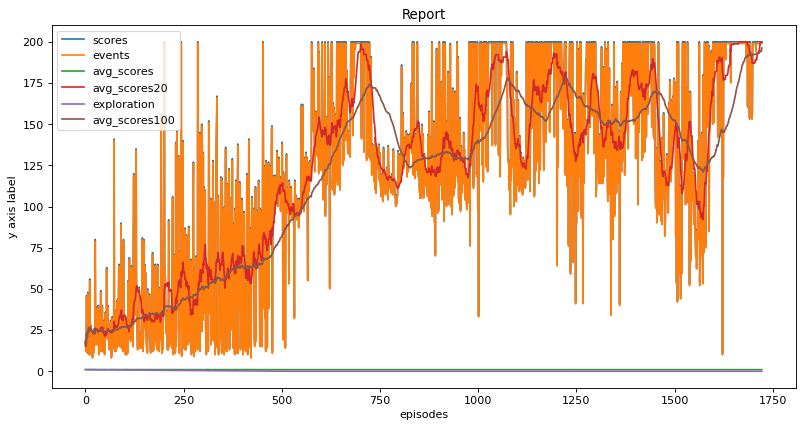

Could not find video
DQN_128_1_001_2e-03_099_1e-04_099
0 of 2000
13.0 13 13.0 13.0
14.0 14 13.5 13.5
19.0 19 15.333333333333334 15.333333333333334
29.0 29 18.75 18.75
37.0 37 20.181818181818183 20.181818181818183
44.0 44 20.25 20.25
64.0 64 23.72222222222222 23.72222222222222
25 of 2000
50 of 2000
75 of 2000
72.0 72 31.65 25.23076923076923
89.0 89 32.0 25.88095238095238
100 of 2000
94.0 94 30.95 27.75
125 of 2000
125.0 125 35.4 29.66
172.0 172 44.95 33.02
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
200.0 200 100.8 74.05
350 of 2000
200.0 200 122.8 80.71
200.0 200 118.2 90.38
375 of 2000
200.0 200 139.45 100.23
200.0 200 144.9 102.94
200.0 200 158.7 111.57
200.0 200 161.95 113.37
200.0 200 162.35 115.9
200.0 200 165.5 117.41
200.0 200 168.55 118.27
400 of 2000
200.0 200 169.65 120.45
200.0 200 166.7 127.59
200.0 200 154.4 136.53
425 of 2000
450 of 2000
200.0 200 147.1 148.3
200.0 200 165.0 154.62
475 of 2000
200.0 200 172.05 157.7
200.

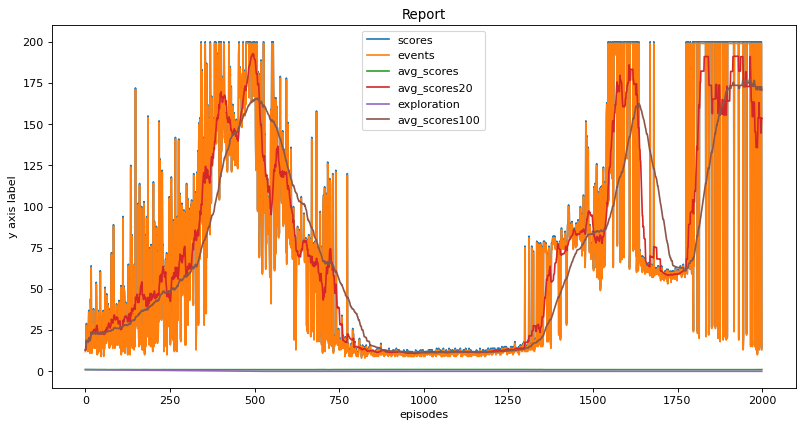

Could not find video
DQN_128_1_001_2e-03_099_1e-05_099
0 of 2000
45.0 45 45.0 45.0
54.0 54 24.1875 24.1875
25 of 2000
50 of 2000
61.0 61 22.3 22.875
75 of 2000
100 of 2000
125 of 2000
105.0 105 21.15 21.39
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
105.0 105 89.7 71.2
450 of 2000
475 of 2000
106.0 106 99.7 87.85
500 of 2000
106.0 106 101.25 92.97
106.0 106 101.65 94.74
106.0 106 101.9 94.86
525 of 2000
107.0 107 101.3 97.82
107.0 107 101.55 97.93
108.0 108 101.9 98.08
550 of 2000
108.0 108 102.65 100.26
575 of 2000
600 of 2000
625 of 2000
108.0 108 103.3 102.75
650 of 2000
675 of 2000
700 of 2000
108.0 108 102.8 102.79
725 of 2000
750 of 2000
108.0 108 101.6 102.36
108.0 108 101.85 102.51
775 of 2000
800 of 2000
108.0 108 102.05 102.54
109.0 109 102.45 102.57
825 of 2000
109.0 109 103.6 102.6
109.0 109 103.85 102.63
850 of 2000
875 of 2000
109.0 109 103.1 102.15
900 of 2000
925 of 2000


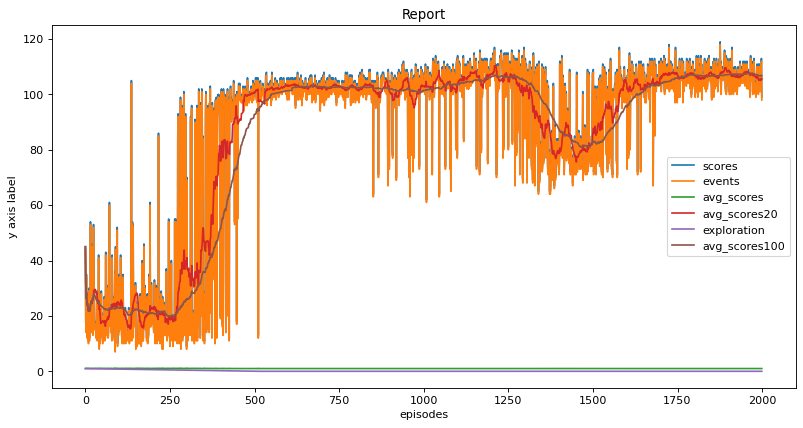

Could not find video
DuelingDQN_128_1_001_2e-03_099_1e+00_099
0 of 2000
21.0 21 21.0 21.0
25.0 25 17.6 17.6
53.0 53 21.714285714285715 21.714285714285715
25 of 2000
50 of 2000
59.0 59 23.65 22.45098039215686
75 of 2000
60.0 60 24.35 21.571428571428573
63.0 63 28.0 22.237113402061855
100 of 2000
125 of 2000
150 of 2000
136.0 136 27.5 23.04
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
1475 of 2000
150

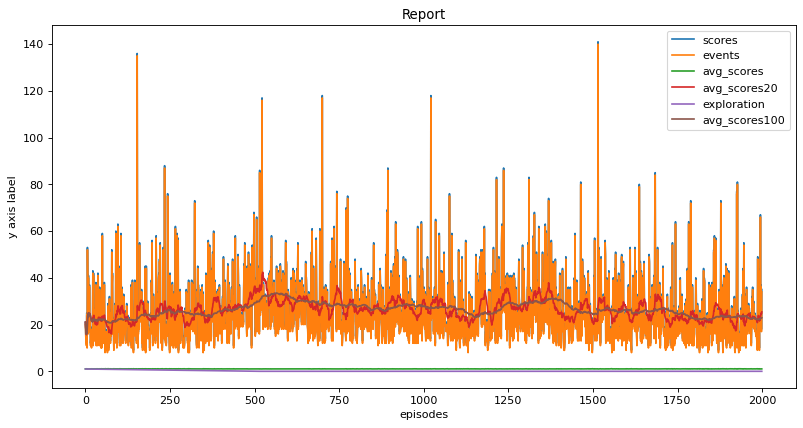

Could not find video
DuelingDQN_128_1_001_2e-03_099_1e-01_099
0 of 2000
11.0 11 11.0 11.0
11.0 11 11.0 11.0
30.0 30 17.333333333333332 17.333333333333332
33.0 33 21.166666666666668 21.166666666666668
33.0 33 23.25 23.25
39.0 39 25.0 25.0
41.0 41 25.09090909090909 25.09090909090909
25 of 2000
58.0 58 20.7 21.428571428571427
50 of 2000
75 of 2000
100 of 2000
60.0 60 21.35 21.39
125 of 2000
61.0 61 23.0 21.96
150 of 2000
175 of 2000
69.0 69 21.15 21.98
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
73.0 73 18.3 16.95
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000


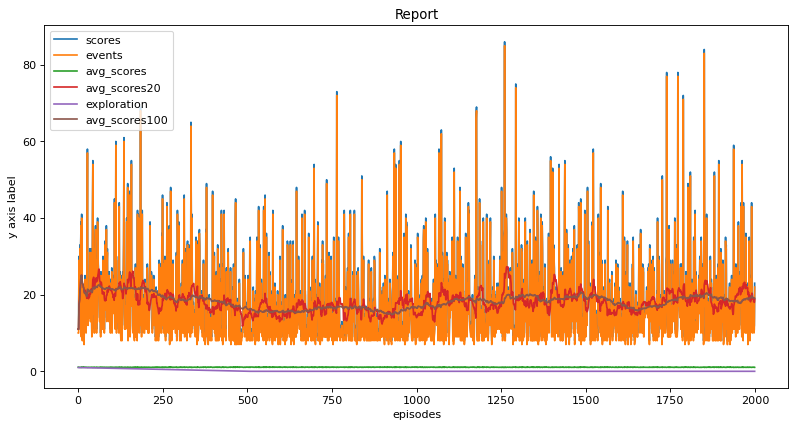

Could not find video
DuelingDQN_128_1_001_2e-03_099_1e-02_099
0 of 2000
27.0 27 27.0 27.0
33.0 33 21.8 21.8
33.0 33 21.416666666666668 21.416666666666668
46.0 46 20.75 20.695652173913043
25 of 2000
48.0 48 22.4 21.384615384615383
54.0 54 24.45 22.2
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
54.0 54 16.25 17.35
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
60.0 60 15.0 13.17
650 of 2000
675 of 2000
700 of 2000
66.0 66 19.45 14.37
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
79.0 79 18.4 14.76
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 200

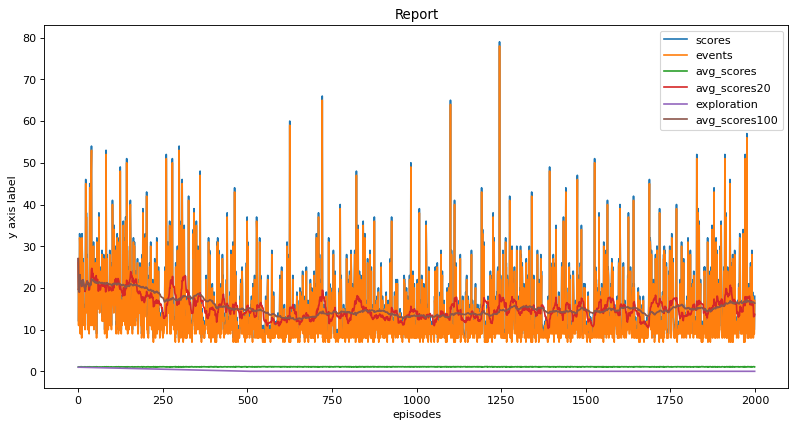

Could not find video
DuelingDQN_128_1_001_2e-03_099_1e-01_099
0 of 2000
21.0 21 21.0 21.0
22.0 22 19.0 19.0
25.0 25 20.0 20.0
44.0 44 22.75 22.75
45.0 45 22.7 22.7
25 of 2000
50.0 50 24.9 23.10810810810811
58.0 58 23.4 22.863636363636363
50 of 2000
58.0 58 22.5 22.527027027027028
75 of 2000
67.0 67 22.55 22.595238095238095
100 of 2000
79.0 79 27.6 23.86
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
142

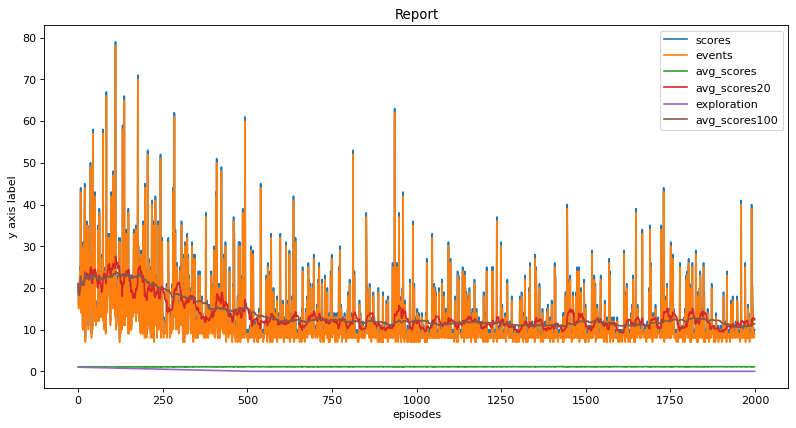

Could not find video
DuelingDQN_128_1_001_2e-03_099_1e-02_099
0 of 2000
14.0 14 14.0 14.0
19.0 19 16.5 16.5
30.0 30 21.0 21.0
30.0 30 22.0 22.0
61.0 61 28.5 28.5
25 of 2000
63.0 63 22.4 24.037037037037038
50 of 2000
80.0 80 21.15 22.105263157894736
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
1475 of 2000
1500 of 2000
1525 of 2000
1550 of 2000
1575 of 2

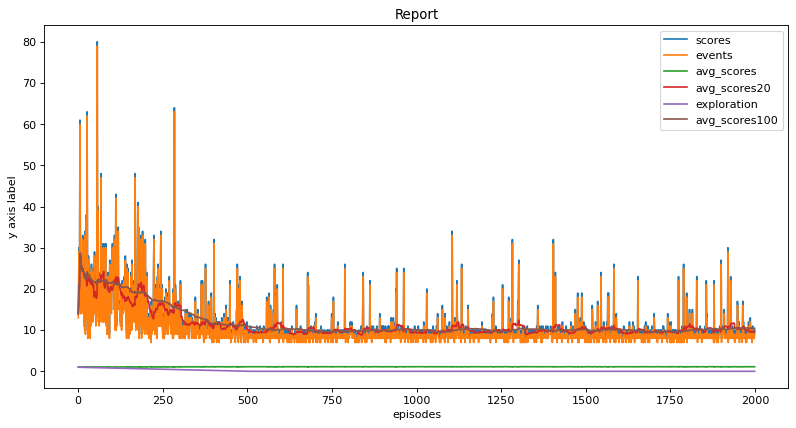

Could not find video
DuelingDQN_128_1_001_2e-03_099_1e-05_099
0 of 2000
19.0 19 19.0 19.0
36.0 36 23.666666666666668 23.666666666666668
36.0 36 26.75 26.75
39.0 39 24.133333333333333 24.133333333333333
55.0 55 23.7 23.695652173913043
25 of 2000
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
1475 of 2000
1500 of 2000
1525 of 2000
1550 of 2000
15

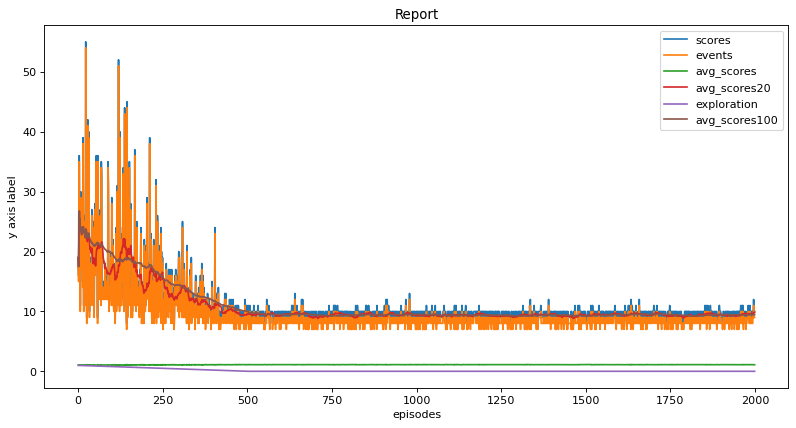

Could not find video
DuelingDQN_128_1_001_2e-03_099_1e-03_099
0 of 2000
25.0 25 25.0 25.0
26.0 26 25.5 25.5
27.0 27 19.272727272727273 19.272727272727273
43.0 43 21.25 21.25
25 of 2000
50 of 2000
72.0 72 23.3 21.20754716981132
75 of 2000
101.0 101 29.2 23.302325581395348
100 of 2000
125 of 2000
108.0 108 36.25 30.38
150 of 2000
158.0 158 36.75 33.57
175 of 2000
200 of 2000
225 of 2000
190.0 190 64.6 42.79
250 of 2000
275 of 2000
197.0 197 66.45 51.95
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
200.0 200 123.55 73.54
450 of 2000
200.0 200 92.05 80.51
200.0 200 95.75 85.32
475 of 2000
200.0 200 123.55 103.57
500 of 2000
200.0 200 129.6 109.05
525 of 2000
550 of 2000
575 of 2000
600 of 2000
200.0 200 104.35 105.26
625 of 2000
200.0 200 117.3 107.86
200.0 200 124.0 109.31
200.0 200 135.35 112.57
200.0 200 141.55 113.25
200.0 200 145.95 114.19
200.0 200 149.95 115.1
200.0 200 135.15 118.87
200.0 200 136.6 119.9
650 of 2000
200.0 200 132.5 125.28
675 of 2000
200.0

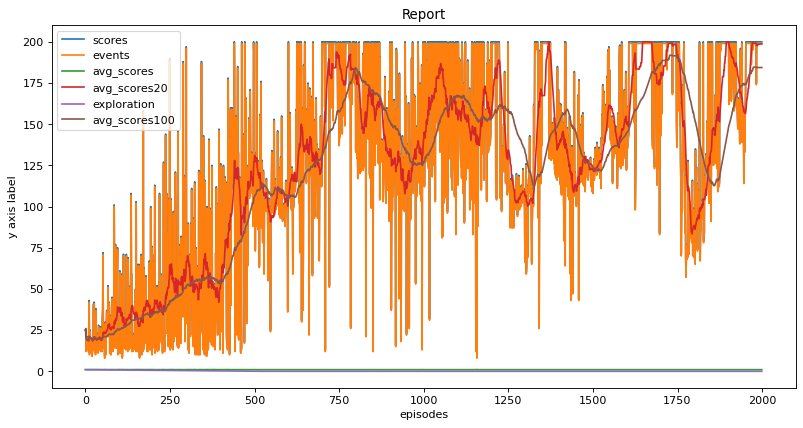

Could not find video
DuelingDQN_128_1_001_2e-03_099_1e-04_099
0 of 2000
12.0 12 12.0 12.0
22.0 22 17.0 17.0
28.0 28 20.666666666666668 20.666666666666668
29.0 29 18.666666666666668 18.666666666666668
35.0 35 19.41176470588235 19.41176470588235
40.0 40 21.1 20.666666666666668
25 of 2000
70.0 70 24.45 22.075
50 of 2000
75 of 2000
81.0 81 30.95 24.82758620689655
93.0 93 33.65 25.608247422680414
118.0 118 38.1 26.41
100 of 2000
125 of 2000
141.0 141 46.9 34.52
155.0 155 51.65 37.06
150 of 2000
185.0 185 55.0 41.38
175 of 2000
200 of 2000
200.0 200 82.3 55.05
225 of 2000
200.0 200 82.0 65.81
200.0 200 83.05 69.55
200.0 200 83.45 70.31
250 of 2000
200.0 200 100.65 79.8
200.0 200 116.35 82.92
200.0 200 124.8 84.46
200.0 200 131.45 86.12
275 of 2000
200.0 200 139.2 87.47
200.0 200 142.0 91.49
200.0 200 143.25 95.18
200.0 200 136.9 96.11
200.0 200 132.3 98.74
200.0 200 121.4 99.08
200.0 200 128.55 99.91
300 of 2000
200.0 200 122.95 100.12
200.0 200 128.15 101.92
200.0 200 129.75 103.42
200.0 20

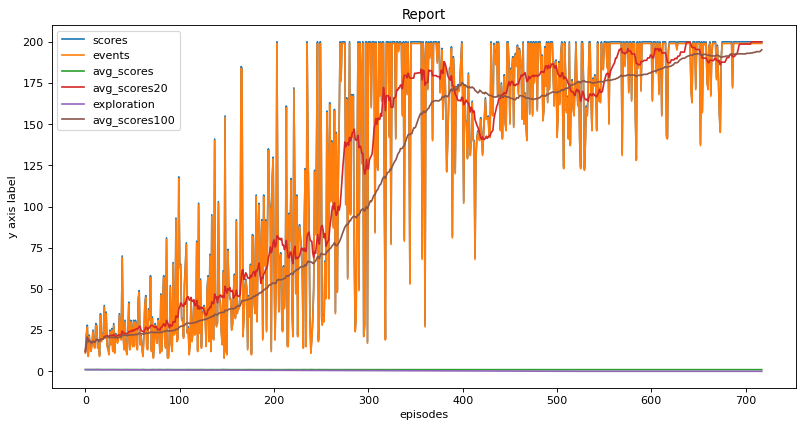

Could not find video
DuelingDQN_128_1_001_2e-03_099_1e-05_099
0 of 2000
17.0 17 17.0 17.0
85.0 85 37.0 37.0
25 of 2000
50 of 2000
89.0 89 23.5 22.403508771929825
106.0 106 35.65 25.705882352941178
75 of 2000
100 of 2000
117.0 117 41.7 30.53
125 of 2000
134.0 134 51.8 35.21
150 of 2000
175 of 2000
140.0 140 58.25 45.1
200 of 2000
200.0 200 54.95 51.53
225 of 2000
200.0 200 92.65 64.51
200.0 200 100.15 66.34
250 of 2000
200.0 200 123.7 75.63
200.0 200 127.2 80.04
200.0 200 132.9 83.37
200.0 200 133.45 87.63
275 of 2000
200.0 200 141.95 90.22
200.0 200 142.6 94.51
200.0 200 141.0 99.64
200.0 200 137.65 103.43
200.0 200 141.85 106.7
200.0 200 142.55 109.85
200.0 200 145.45 111.21
300 of 2000
200.0 200 157.35 115.74
200.0 200 163.7 117.52
200.0 200 166.0 118.91
200.0 200 166.15 121.16
200.0 200 166.15 121.76
200.0 200 174.7 124.38
200.0 200 175.1 126.92
200.0 200 177.6 129.0
200.0 200 164.4 130.89
325 of 2000
200.0 200 160.9 137.36
200.0 200 160.9 139.2
200.0 200 159.3 140.14
200.0 200 159.

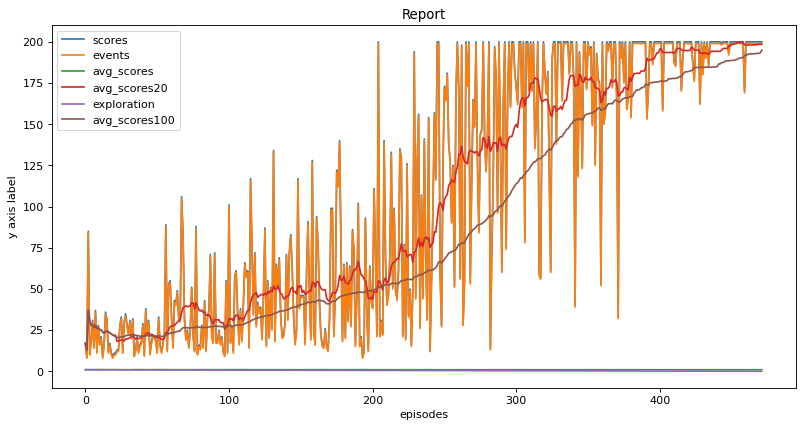

Could not find video


In [7]:


# Sim configuration
env = gym.make("CartPole-v0")
spec = gym.spec("CartPole-v0")



inputs=4
n_actions=2

#hyper-parameters
TotalEpisodes=2000
MaxSteps=400
FreezeCounter=25
BatchSize=128
exploration_threshold=1
exploration_threshold_min=0.01
exploration_decay=0.002
discount_factor=0.99
SaveAtCounter=200
LearningRateDecay=0.99


# arch = "DQN"

#network DQN


buffer = ReplayBuffer(1000000, inputs,device);

# print(policy_net)
for arch in ["DQN","DuelingDQN"]:
    file_path__ = mt.create_dir("results",arch)
    for n_layers in [0]:#,1,3]:
        policy_net, target_net = archs.archs(arch,inputs,n_actions,discount_factor,device,n_layers)
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()
        file_path_ = mt.create_dir(file_path__,"N"+str(n_layers)+"_Layers")
        for LearningRate in [1,0.1,0.01,0.001]:
            # if(n_layers == 0 and (LearningRate == 0.001 or LearningRate == 0.0001 or LearningRate == 0.00001)):
            #     continue
            # if(n_layers == 1 and (LearningRate == 0.001 or LearningRate == 0.0001 or LearningRate == 1)):
            #     continue
            # if(n_layers == 3 and (LearningRate == 1 or LearningRate == 0.1 or LearningRate == 0.01)):
            #     continue
            optimizer = torch.optim.Adam(policy_net.parameters(), lr=LearningRate)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=LearningRateDecay)
            loss = torch.nn.MSELoss()
            def trainModel():
                if buffer.counter < BatchSize:
                    return 0.0
                
                state_batch, action_batch, reward_batch, new_state_batch, done_batch = buffer.sample_buffer(BatchSize)

                q_actual = torch.gather(policy_net(state_batch),1,action_batch.reshape(-1,1))
                with torch.no_grad():
                    q_max_next = target_net(new_state_batch).max(1)[0].detach()
                q_target = (q_max_next * discount_factor)*(1-done_batch) + reward_batch

                ll=loss(q_actual, q_target.unsqueeze(1))

                # Optimize the model
                optimizer.zero_grad()
                ll.backward()
                for param in policy_net.parameters():
                    param.grad.data.clamp_(-1, 1)
                optimizer.step()

                return ll.item();
            file_name = mt.set_name(arch,BatchSize,exploration_threshold,exploration_threshold_min,exploration_decay,discount_factor,LearningRate,LearningRateDecay)
            file_path = mt.create_dir(file_path_,file_name)
            mt.create_dir(file_path,"Checkpoints")
            print(file_name)
            bestNet, episodes, scores, events, avg_scores, avg_scores20, exploration, avg_scores100 = tl.train_loop(policy_net, target_net, env, device, TotalEpisodes, FreezeCounter, SaveAtCounter, createMovie, MaxSteps, exploration_threshold, exploration_decay, exploration_threshold_min, buffer, trainModel,file_path)

            eval.performance_evaluation(file_path,episodes, scores, events, avg_scores, avg_scores20, exploration, avg_scores100)
            eval.report(file_path,arch,BatchSize,exploration_threshold,exploration_threshold_min,exploration_decay,discount_factor,
                        LearningRate,LearningRateDecay,episodes, scores, events, avg_scores, avg_scores20, exploration, n_layers,avg_scores100)
            createMovie(bestNet,file_path,'bestNet')
            time.sleep(1)